# Branded food data frame analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
filepath = lambda x: os.path.join('data', x)

In [3]:
branded_food = pd.read_csv(filepath('branded_food.csv'), dtype={
    'brand_owner':str,
    'brand_name':str,
    'subbrand_name':str,
    'gtin_upc':str})
branded_food.head()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_17060\1118146348.py:1: DtypeWarning: Columns (6,9,12,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  branded_food = pd.read_csv(filepath('branded_food.csv'), dtype={


,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
0,1105904,Richardson Oilseed Products (US) Limited,NaN,NaN,00027000612323,Vegetable Oil,NaN,15.0,ml,NaN,Oils Edible,GDSN,NaN,2020-10-02,2020-11-13,United States,NaN,NaN,NaN,NaN
1,1105905,CAMPBELL SOUP COMPANY,NaN,NaN,00051000198808,"INGREDIENTS: BEEF STOCK, CONTAINS LESS THAN 2%...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-09-12,2020-11-13,United States,NaN,NaN,NaN,NaN
2,1105906,CAMPBELL SOUP COMPANY,NaN,NaN,00051000213273,"INGREDIENTS: CLAM STOCK, POTATOES, CLAMS, CREA...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
3,1105907,CAMPBELL SOUP COMPANY,NaN,NaN,00051000213303,"INGREDIENTS: WATER, CREAM, BROCCOLI, CELERY, V...",NaN,440.0,g,NaN,Prepared Soups,GDSN,NaN,2020-09-01,2020-11-13,United States,NaN,NaN,NaN,NaN
4,1105908,CAMPBELL SOUP COMPANY,NaN,NaN,00051000224637,"INGREDIENTS: CHICKEN STOCK, CONTAINS LESS THAN...",NaN,240.0,ml,NaN,Herbs/Spices/Extracts,GDSN,NaN,2020-10-03,2020-11-13,United States,NaN,NaN,NaN,NaN


Going through the initial inspection of the dataset:

- Missingness/null values
- incorrect dtypes
- Reducing of columns/memory if possible]
- Validation of data (outlier searching and correction of incorrect values)

## Initial Missingness check

In [4]:
branded_food.isnull().mean()

fdc_id                         0.000000
brand_owner                    0.007813
brand_name                     0.296762
subbrand_name                  0.952827
gtin_upc                       0.000000
ingredients                    0.002923
not_a_significant_source_of    0.960171
serving_size                   0.005842
serving_size_unit              0.010312
household_serving_fulltext     0.585086
branded_food_category          0.005729
data_source                    0.000000
package_weight                 0.617388
modified_date                  0.000011
available_date                 0.000000
market_country                 0.000000
discontinued_date              1.000000
preparation_state_code         0.978783
trade_channel                  0.991557
short_description              0.978720
dtype: float64

We see that there are some columns with missing data, mainly towards the end, including discontinued_date, preparation_state_code, trade_channel, and short_description, which we will take a look through non-null examples and drop if necessary to preserve memory.

In [5]:
has_prep_code = branded_food[branded_food.preparation_state_code.notnull()]
has_prep_code.head()

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1549669,2219410,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205546077,"Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1 LBR,2019-03-07,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 93% Grd Tky Chub 12/1
1549670,2219411,Cargill Incorporated/Honeysuckle White,Honeysuckle White,NaN,00642205534517,"All Natural White Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-04,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh Gr WhtDry Ex Wt 6/1.25#
1549671,2219412,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205534500,"All Natural Turkey, Natural Flavoing",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-05,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 85/15 Gr tky Ex Wt 6/1.25
1549672,2219413,Kellogg Company US,Kellogg's Pop-Tarts,NaN,00038000317101,"Enriched flour (wheat flour, niacin, reduced i...",NaN,52.0,g,1 Pastry,Sweet Bakery Products,GDSN,14.7 ONZ,2019-04-09,2022-02-10,United States,NaN,UNPREPARED,NaN,Pop-Tarts
1549673,2219414,Kellogg Company US,Kellogg's Cheez It,NaN,00024100105236,"Enriched flour (wheat flour, niacin, reduced i...",NaN,25.0,g,1 Pouch,Biscuits/Cookies,GDSN,12.6 ONZ,2019-04-30,2022-02-10,United States,NaN,UNPREPARED,NaN,Gripz Crackers


In [6]:
has_prep_code.preparation_state_code.value_counts()

UNPREPARED        26631
PREPARED           5676
READY_TO_EAT       2830
READY_TO_DRINK     2677
BAKE                603
HEAT_AND_SERVE      272
THAW                147
FREEZE               97
GRILL                95
CONVECTION           36
UNSPECIFIED          22
FRY                  15
STEAM                12
DEEP_FRY             12
ROAST                11
BOIL                  7
MICROWAVE             4
STIR_FRY              4
Name: preparation_state_code, dtype: int64

We see that many of these are with respect to how to prepare the food for consumption, many of which are simply labeled "unprepared" or prepared. We also see that many of these preparation codes are disambiguous, as unprepared does contain also foods that would be considered ready to eat, such as Pop-Tarts or Cheez-its. Because of this, it may be hard to categorize food into explicitly "prepared" and "unprepared" categories.

In [7]:
has_prep_code[has_prep_code.preparation_state_code == 'UNPREPARED'].head(5)

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1549669,2219410,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205546077,"Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1 LBR,2019-03-07,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 93% Grd Tky Chub 12/1
1549670,2219411,Cargill Incorporated/Honeysuckle White,Honeysuckle White,NaN,00642205534517,"All Natural White Turkey, Natural Flavoring",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-04,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh Gr WhtDry Ex Wt 6/1.25#
1549671,2219412,Cargill Incorporated/Honeysuckle White,HONEYSUCKLE WHITE,NaN,00642205534500,"All Natural Turkey, Natural Flavoing",NaN,112.0,g,4 oz.,Meat/Poultry/Other Animals Unprepared/Unproce...,GDSN,1.25 LBR,2020-02-05,2022-02-10,United States,NaN,UNPREPARED,NaN,HSW Fh 85/15 Gr tky Ex Wt 6/1.25
1549672,2219413,Kellogg Company US,Kellogg's Pop-Tarts,NaN,00038000317101,"Enriched flour (wheat flour, niacin, reduced i...",NaN,52.0,g,1 Pastry,Sweet Bakery Products,GDSN,14.7 ONZ,2019-04-09,2022-02-10,United States,NaN,UNPREPARED,NaN,Pop-Tarts
1549673,2219414,Kellogg Company US,Kellogg's Cheez It,NaN,00024100105236,"Enriched flour (wheat flour, niacin, reduced i...",NaN,25.0,g,1 Pouch,Biscuits/Cookies,GDSN,12.6 ONZ,2019-04-30,2022-02-10,United States,NaN,UNPREPARED,NaN,Gripz Crackers


## Serving size cleaning

In [8]:
branded_food.serving_size_unit.value_counts()

g      1522350
ml      243399
GRM      40597
MLT       8288
MG        7555
IU        3671
GM         346
MC          63
Name: serving_size_unit, dtype: int64

We see that there are several options. We will look up what these units exactly mean (unabbreviated), and possibly merge any containing the same amount. We can also visualize the distributions of respective foods.

- g (gram)
- ml (mililiter, most likely for fluids)
- grm - unknown, will compare to gram's distribution for differences
- mlt - Unknwon
- MG - possibly a milligram distribution
- IU - 

In [9]:
grm_foods = branded_food[branded_food.serving_size_unit == 'GRM']
grm_foods

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1751470,2456687,SCHWAN'S FOOD SERVICE INC,TONY'S,NaN,10072180726718,"INGREDIENTS: FRENCH BREAD (WATER, WHITE WHOLE ...",NaN,156.0,GRM,1 Pizza (156g),Pies/Pastries/Pizzas/Quiches - Savoury (Frozen),GDSN,60 EA,2022-12-15,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS""]",TN FB WG CHS 100
1751471,2456688,Bake Crafters Food Company,Bake Crafters,NaN,00737410335001,"Enriched Wheat Flour [Wheat Flour, Malted Barl...",NaN,28.0,GRM,1 oz (28g),Bread (Frozen),GDSN,6.25 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,NaN,"Pullman Bread, White, 1 Slice, IW"
1751472,2456689,Bake Crafters Food Company,Bake Crafters,NaN,00737410171708,"Whole Wheat Flour, Enriched Bleached Wheat Flo...",NaN,78.0,GRM,"2.75 oz (78g), 4 pieces",Desserts (Frozen),GDSN,12.375 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS"",""CHILD_NUTRIT...","Mini Breakfast Bites, Glz, WG, 4 Pk"
1751473,2456690,Bake Crafters Food Company,Bake Crafters,NaN,00737410158105,"Water, Whole Wheat Flour, Enriched Wheat Flour...",NaN,40.0,GRM,"1.4 oz (40g), 2 Pancakes",Bread (Frozen),GDSN,14.175 LBR,2022-06-02,2023-01-26,United States,NaN,UNPREPARED,"[""CHILD_NUTRITION_FOOD_PROGRAMS"",""CHILD_NUTRIT...",Pancakes WG Wholesome Choice Mpl Ch
1751474,2456691,Brakebush Brothers,Brakebush,NaN,10038034558706,UNCOOKED BONELESS CHICKEN BREAST TENDERS CONTA...,NaN,71.0,GRM,1 Piece,Chicken - Prepared/Processed,GDSN,10 LBR,2022-04-26,2023-01-26,United States,NaN,UNPREPARED,NaN,Crispy-Lishus tenders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845290,2554908,Tanjoe Enterprises Inc.,LIDIA'S,NaN,897712001049,"ITALIAN TOMATOES (CITRIC ACID), ARTICHOKES, CA...",NaN,125.0,GRM,1/2 cup,Prepared Pasta & Pizza Sauces,LI,25 oz/708 g,2023-03-27,2023-05-25,United States,NaN,NaN,NaN,NaN
1845291,2554909,Oregon Growers & Shippers LLC,OREGON GROWERS,NaN,898271000948,"BLACKBERRIES (MARIONBERRIES, BLACKBERRIES), CA...","Not a significant source of saturated fat, tra...",39.0,GRM,2 Tbsp,Syrups & Molasses,LI,8 fl oz/237 mL,2023-04-26,2023-05-25,United States,NaN,NaN,NaN,NaN
1845292,2554910,Mt. Garfield Winery Corp,LIFESTYLEFOODS,NaN,898425002682,ARCADIAN HARVEST LETTUCE (BLEND OF LEAF LETTUC...,NaN,163.0,GRM,NaN,"Pickles, Olives, Peppers & Relishes",LI,5.75 oz./163 g,2023-03-10,2023-05-25,United States,NaN,NaN,NaN,NaN
1845295,2554913,"Ittella International, Inc.",TATTOOED CHEF,NaN,899764001527,"CAULIFLOWER, CORN FLOUR, GRANA PADANO CHEESE (...",NaN,71.0,GRM,1 pc,Frozen Patties and Burgers,LI,10 oz/283 g,2023-03-23,2023-05-25,United States,NaN,NaN,NaN,NaN


One thing to note is the serving size amount of grm corresponding to the household serving fulltext. We can see many examples where the gram amount corresponds to what is labeled in household serving fulltext:

In [10]:
(
    grm_foods[grm_foods.household_serving_fulltext.str.contains('g)', regex=False).fillna(False)]
    [['serving_size', 'serving_size_unit', 'household_serving_fulltext']]
)

,serving_size,serving_size_unit,household_serving_fulltext
1751470,156.0,GRM,1 Pizza (156g)
1751471,28.0,GRM,1 oz (28g)
1751472,78.0,GRM,"2.75 oz (78g), 4 pieces"
1751473,40.0,GRM,"1.4 oz (40g), 2 Pancakes"
1751477,34.0,GRM,"1.19 oz (34g), 1 Bread Stick"
...,...,...,...
1841730,4.0,GRM,2 Tbsp (4g)
1841731,79.0,GRM,"2.8 oz (79g), 1 Biscuit"
1842987,61.0,GRM,2/3 cup dry mix (61g) (1cup prepared)
1842989,61.0,GRM,1 link (g)


From this we can most likely consider **grm** as synonymous with the **g** abbreviation. 

In [11]:
g_foods = branded_food[branded_food.serving_size_unit == 'g']
g_foods[g_foods.household_serving_fulltext.str.contains('g)', regex=False).fillna(False)][['serving_size', 'serving_size_unit', 'household_serving_fulltext']]

,serving_size,serving_size_unit,household_serving_fulltext
34110,17.0,g,1 Tbsp (17g)
34285,17.0,g,1 Tbsp(17g)
34382,62.0,g,1/4 cup (62g)
34383,62.0,g,1/4 cup (62g)
34384,62.0,g,1/4 cup (62g)
...,...,...,...
1757337,54.0,g,3 sheets (3x18g) dry
1759907,85.0,g,1 cup salad only/ 1 cup dressed salad with top...
1760115,85.0,g,1 cup salad only/1 cup dressed salad with topp...
1776928,85.0,g,"1 Cup Vegetables (85 g), 4 pieces Sausage (16 ..."


If we only look at these examples, we would consider them as conventionally the same. However, they may not be the same exactly. One way we can possibly further reinforce this idea is through a permutation test; if we assume that they're from the same distribution, then the two distributions should be similar to each other.

## Gram permutation test

Because the amount of foods there are between the two, we will instead choose to sample the distributions to about 10,000 for each distribution. We will also eliminate some of the outliers, as we noticed from the descriptive statistics (mainly the max) of g foods.

In [27]:
g_stats = g_foods.serving_size.describe()
g_stats

count    1.522350e+06
mean     4.005529e+02
std      2.935550e+05
min      0.000000e+00
25%      2.800000e+01
50%      4.000000e+01
75%      8.500000e+01
max      2.561132e+08
Name: serving_size, dtype: float64

<AxesSubplot:ylabel='Frequency'>

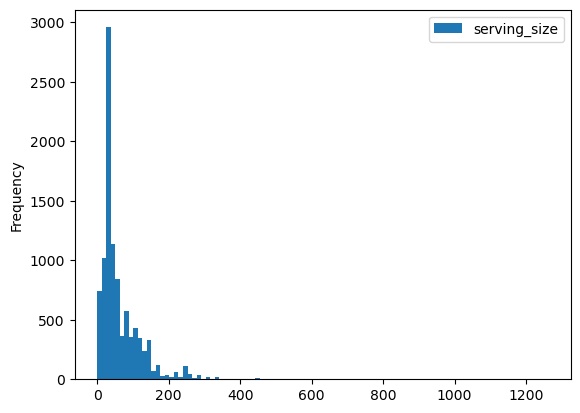

In [17]:
g_foods.sample(10000).plot(kind='hist', y='serving_size', bins=100)

<AxesSubplot:ylabel='Frequency'>

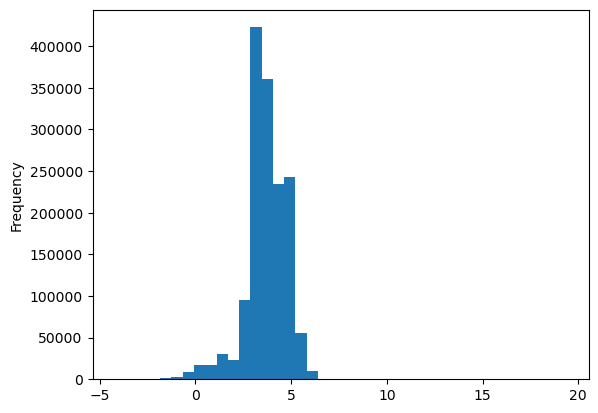

In [26]:
g_foods[g_foods.serving_size >= 0.001].serving_size.apply(np.log).plot(kind='hist', bins=40)

From many of the graphs, we can see that serving sizes above 600 are about rare. However, we can also possibly square root the graph to make it less receptive to outliers. A log transformation may not be possible as well, as some of the entries are 0, making log impossible. We will simply turn to the Box Plot method of removing outliers, where we consider anything above the 75% point (Q3) + 1.5 * (Q3 - Q1) to be an outlier, as well as anything below (Q1) - 1.5 * (Q3 - Q1).

<AxesSubplot:ylabel='Frequency'>

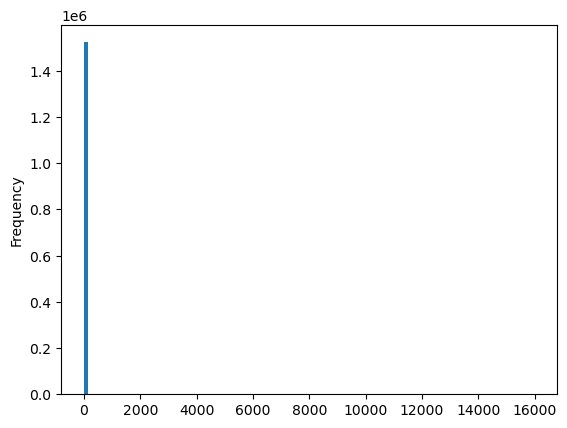

In [22]:
g_foods.serving_size.apply(np.sqrt).plot(kind='hist', bins=100)

In [35]:
g_food_iqr = g_stats.loc['75%'] - g_stats.loc['25%']
g_food_iqr

57.0

In [37]:
g_lower_outlier_bound = g_stats.loc['25%'] - 1.5 * g_food_iqr
g_lower_outlier_bound # Lower than zero, so we can ignore lower bounded outliers as there are none

-57.5

In [39]:
g_upper_bound = g_stats.loc['75%'] + 1.5 * g_food_iqr
g_upper_bound

170.5

In [43]:
g_foods_no_outlier = g_foods[g_foods.serving_size <= g_upper_bound]
print(g_foods.shape[0] - g_foods_no_outlier.shape[0], 'rows removed')

69578 rows removed


In [45]:
(g_foods.shape[0] - g_foods_no_outlier.shape[0]) / g_foods.shape[0] # Only 5% of the data was removed as outliers

0.04570433868689854

We repeat the process with grm foods:

In [49]:
grm_stats = grm_foods.serving_size.describe()
grm_stats

count    40597.000000
mean        64.826811
std         83.239828
min          0.060000
25%         28.000000
50%         36.000000
75%         88.000000
max       9979.000000
Name: serving_size, dtype: float64

One thing to point out is that the quantile statistics (25%, 50%, 75%) are similar between g and grm.

In [50]:
grm_iqr = grm_stats.loc['75%'] - grm_stats.loc['25%']
grm_iqr # This number exceeds the 25%, so we do not have to calculate lower bound

60.0

In [51]:
grm_upper_bound = grm_stats.loc['75%'] + grm_iqr * 1.5
grm_upper_bound # Also not too far off from gram's 75% 

178.0

In [55]:
grm_foods_no_outlier = grm_foods[grm_foods.serving_size <= grm_upper_bound]
(grm_foods.shape[0] - grm_foods_no_outlier.shape[0]) / grm_foods.shape[0] # Also removed about 5% of the data

0.05197428381407493

We will run permutation by both median and mean.

In [61]:
pd.concat([g_foods_no_outlier.sample(10000, replace=False), grm_foods_no_outlier])

,fdc_id,brand_owner,brand_name,subbrand_name,gtin_upc,ingredients,not_a_significant_source_of,serving_size,serving_size_unit,household_serving_fulltext,branded_food_category,data_source,package_weight,modified_date,available_date,market_country,discontinued_date,preparation_state_code,trade_channel,short_description
1342888,1995365,Meyer Natural Foods LLC,LAURA'S,NaN,612669333360,"VEGAN TENDER. WATER, SOY PROTEIN CONCENTRATE, ...",NaN,96.0,g,NaN,Vegetarian Frozen Meats,LI,10.20 oz/289 g,2021-03-19,2021-07-29,United States,NaN,NaN,NaN,NaN
70975,382628,Target Stores,NaN,NaN,085239731086,"MILKFAT AND NONFAT MILK, SUGAR, SWEET CREAM BU...",NaN,65.0,g,0.5 cup,Ice Cream & Frozen Yogurt,LI,NaN,2018-01-26,2019-04-01,United States,NaN,NaN,NaN,NaN
1151412,1765518,"Ahold USA, Inc.",AHOLD,NaN,688267164101,"SUGAR, WHOLE EGGS, WHEAT FLOUR, CANOLA OIL, WH...",NaN,62.0,g,NaN,Crusts & Dough,LI,500 g,2018-07-03,2021-06-17,United States,NaN,NaN,NaN,NaN
767550,1365090,Kingston Marketing Co,VALU TIME,NaN,011225557101,"SALT, MONOSODIUM GLUTAMATE, SPICES (INCLUDING ...",NaN,1.0,g,NaN,"Seasoning Mixes, Salts, Marinades & Tenderizers",LI,NaN,2019-07-09,2021-02-26,United States,NaN,NaN,NaN,NaN
388917,822534,"Schnuck Markets, Inc.",NaN,NaN,041318010626,"BLUEBERRIES, WATER, SUGAR, MODIFIED CORN STARC...",NaN,85.0,g,1/3 cup,Pastry Shells & Fillings,LI,NaN,2020-04-09,2020-05-28,United States,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845290,2554908,Tanjoe Enterprises Inc.,LIDIA'S,NaN,897712001049,"ITALIAN TOMATOES (CITRIC ACID), ARTICHOKES, CA...",NaN,125.0,GRM,1/2 cup,Prepared Pasta & Pizza Sauces,LI,25 oz/708 g,2023-03-27,2023-05-25,United States,NaN,NaN,NaN,NaN
1845291,2554909,Oregon Growers & Shippers LLC,OREGON GROWERS,NaN,898271000948,"BLACKBERRIES (MARIONBERRIES, BLACKBERRIES), CA...","Not a significant source of saturated fat, tra...",39.0,GRM,2 Tbsp,Syrups & Molasses,LI,8 fl oz/237 mL,2023-04-26,2023-05-25,United States,NaN,NaN,NaN,NaN
1845292,2554910,Mt. Garfield Winery Corp,LIFESTYLEFOODS,NaN,898425002682,ARCADIAN HARVEST LETTUCE (BLEND OF LEAF LETTUC...,NaN,163.0,GRM,NaN,"Pickles, Olives, Peppers & Relishes",LI,5.75 oz./163 g,2023-03-10,2023-05-25,United States,NaN,NaN,NaN,NaN
1845295,2554913,"Ittella International, Inc.",TATTOOED CHEF,NaN,899764001527,"CAULIFLOWER, CORN FLOUR, GRANA PADANO CHEESE (...",NaN,71.0,GRM,1 pc,Frozen Patties and Burgers,LI,10 oz/283 g,2023-03-23,2023-05-25,United States,NaN,NaN,NaN,NaN


In [94]:
def test_stat(data, category, val_column, apply_func):
    return np.abs(data.groupby(category)[val_column].agg(apply_func).diff().iloc[-1])

def perm_test(apply_func, dist1, dist2, sample_size, category, val_column):
    """ Compute an (approximate) permutation test between two distributions using either median or mean. 
        Returns the p-value corresponding to the likelihood that the distributions are the same broader distribution. """
    # Sample stat
    obs_stat = test_stat(pd.concat([dist1, dist2]), category, val_column, apply_func)
    
    # Create a dataset sampling both distributions equally
    sample = pd.concat([dist1.sample(sample_size, replace=False), dist2.sample(sample_size, replace=False)])
    
    # Shuffle around the label, and aggregate with apply function
    sample_stat = test_stat(sample, category, val_column, apply_func)
    
    return obs_stat, sample_stat

In [91]:
apply_func, dist1, dist2, sample_size, category, val_column = 'median', g_foods, grm_foods, 10000, 'serving_size_unit', 'serving_size'

In [93]:
sample = pd.concat([dist1.sample(sample_size, replace=False), dist2.sample(sample_size, replace=False)])

In [67]:
obs_stat = pd.concat([g_foods, grm_foods]).groupby('serving_size_unit')['serving_size'].agg('mean').diff()
obs_stat

serving_size_unit
GRM          NaN
g      335.72609
Name: serving_size, dtype: float64

In [53]:
g_foods_no_outlier.shape

(1452772, 20)

In [ ]:
g_foods_no_outlier.sample(10000)